# Tabular Playground Series - Jul 2021

In [1]:

import matplotlib.pyplot as plt
import torch as t
from torch.utils.data.dataloader import DataLoader as dl
from torch.utils.data import TensorDataset, Dataset, Subset
# from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.linear_model import BayesianRidge as bayR
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor as gradB
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler as ss
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as mslr
from joblib import parallel_backend # to improve sklearn training speed
import os
import datetime
from tensorboardX import SummaryWriter
from sklearn.decomposition import PCA
import optuna as opt
from optuna.integration import PyTorchLightningPruningCallback
import pickle

from scipy import stats
from scipy import optimize as sciOpt

from pymoo.algorithms.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.model.problem import FunctionalProblem
from pymoo.factory import get_termination
from pymoo.visualization.scatter import Scatter

from pymoo.util.display import Display


In [3]:


class MyDisplay(Display):
    
    def _do(self, problem, evaluator, algorithm):
        super()._do(problem, evaluator, algorithm)
        self.output.append("X", np.mean(algorithm.pop.get("X")))
        self.output.append("F", np.mean(algorithm.pop.get("F")))


class LitModel(pl.LightningModule):

    def __init__(self, x, trial=None):
        super().__init__()
        if trial is not None:
            self.lr = trial.suggest_float("lr", minLr, maxLr)
            self.weight_decay =  trial.suggest_float("weight_decay", minWD, maxWD)
        else:
            self.lr = bestDictLightning["lr"]
            self.weight_decay =  bestDictLightning["weight_decay"]
        self.model = makeModel(trial, bestDictLightning)

    def forward(self, x):
        return self.model(x.view(x.size(0), -1))

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss, prog_bar=True,on_epoch=True)
        return loss

    def configure_optimizers(self):
       return t.optim.Adam(self.parameters(), 
                           lr=(self.lr or self.learning_rate))

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss =F.mse_loss(y_hat, y)
        self.log('val_loss', val_loss, prog_bar=True,on_epoch=True)
        return val_loss



class net(nn.Module):

    def __init__(self, x, y):
        super().__init__()
        self.xShape = x.shape
        self.yShape = y.shape
        self.model = nn.Sequential(
            nn.Linear(self.xShape[1],128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,32),
            nn.ReLU(),
            nn.Linear(32,1))

    def forward(self,x):
        return self.model(x)


class dset(Dataset):


    def __init__(self, xAll,yAll):
        super().__init__()
        self.xAll = xAll
        self.yAll = yAll

    def __len__(self):
        return self.xAll.shape[0]

    def __getitem__(self,i):
        x = self.xAll[i]
        y = self.xAll[i]
        return (t.Tensor(x,dtype=t.float), t.Tensor(y,dtype=t.float))


def pickleLoad(filename):
    with open(rf'{filename}','rb') as f:
            return pickle.load(f)

def pickleSave(filename, obj):
    with open(f'{filename}','wb') as f:
        pickle.dump(obj, f)


def makeModel(trial = None, hpDict = None):
    # sets layers and number of neurons for each trial
    #builds dict with parameters that can be used to make best model
    layers=[]
    inFeat = xTrT.shape[1] #assumes 1D data for each sample
    lastOut = yTrT.shape[1]
    if trial is not None:
        nl = trial.suggest_int("nL",minLayers,maxLayers)
        
        for i in range(nl):
            outFeat = trial.suggest_int(f"n{i}",minNeurons,maxNeurons)
            layers.append(nn.Linear(inFeat, outFeat))
            actiLayer = trial.suggest_categorical(f"a{i}",possibleActiFuncs)
            layers.append(getattr(nn, actiLayer)())
            dropOutRatio = trial.suggest_float(f"dropoutL{i}",minDropOut,maxDropOut)
            layers.append(nn.Dropout(dropOutRatio))
            inFeat = outFeat
            
    elif hpDict is not None:
        nl = hpDict["nL"]
        
        for i in range(nl):
            outFeat = hpDict[f"n{i}"]
            layers.append(nn.Linear(inFeat, outFeat))
            actiLayer = hpDict[f"a{i}"]
            layers.append(getattr(nn, actiLayer)())
            dropOutRatio = hpDict[f"dropoutL{i}"]
            layers.append(nn.Dropout(dropOutRatio))
            inFeat = outFeat
            
    layers.append(nn.Linear(inFeat, lastOut))

    return nn.Sequential(*layers)



def runShallowOpt(model, modelname,idxSel):
    with parallel_backend('threading', n_jobs=-1):
        model.fit(xTrT, yTrT)
    yTrPredInvTrans = predictAndInvTransform(xTrT, model)
    yEPredInvTrans = predictAndInvTransform(xET, model)

    mseLoss = mse(yEPredInvTrans, yE)
    rmsleLossTrain = RMSLE(yTrPredInvTrans, yTr)
    rmsleLossEval = RMSLE(yEPredInvTrans, yE)

    #predSub = predictAndInvTransform(teDT,model)
    
    print(modelname,f' TrainLoss {rmsleLossTrain:.3f}, evalLoss: {rmsleLossEval:.3f}')
    return rmsleLossTrain, rmsleLossEval


        
def shallowObjective(trial):

    modelname = trial.suggest_categorical("modelname",possibleShallows)
    idxArr = np.arange(len(xTrT))
    np.random.shuffle(idxArr)
    if numShallowSamples >= len(xTrT):
        idxSel = idxArr
    else:
        idxSel = idxArr[:numShallowSamples]
    if modelname == "SVR":
        C = trial.suggest_float("C",1e0,1e4,log=True)
        kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
        if kernel == 'poly':
            polyDeg = trial.suggest_int("degree",2,6)
        else:
            polyDeg = 3
        if kernel in ['rbf','poly','sigmoid']:
            gamma = trial.suggest_categorical('gamma',['scale', 'auto'])
        else:
            gamma = 'scale'
        if kernel in ['poly','sigmoid']:
            coef0 = trial.suggest_float('coef0',0.,0.2)
        else:
            coef0 = 0.
        model = SVR(kernel=kernel, degree=polyDeg, gamma=gamma, coef0=coef0, C=C,verbose=1)
        multiRegModel = MultiOutputRegressor(model)
        trainLoss, evalLoss = runShallowOpt(multiRegModel, modelname,idxSel)
        
    elif modelname == "rfr":
        n_estimators = trial.suggest_int("n_estimators",10,1000)
        max_features = trial.suggest_categorical("max_features",["sqrt","log2",None])
        max_depth = trial.suggest_int("max_depth",10,100)
        ccp_alpha = trial.suggest_float("ccp_alpha",1e-7,1e0,log=True)
        model = rfr(n_estimators=n_estimators,max_features=max_features,max_depth=max_depth,verbose=1,ccp_alpha=ccp_alpha)
        multiRegModel = MultiOutputRegressor(model)
        trainLoss, evalLoss = runShallowOpt(multiRegModel, modelname,idxSel)
        
    elif modelname == "gradB":
        learning_rate = trial.suggest_float("learning_rate",1e-4,1e0,log=True)
        max_leaf_nodes = trial.suggest_int("max_leaf_nodes",1,500)
        max_depth = trial.suggest_int("max_depth",10,100)
        model = gradB(learning_rate=learning_rate,max_leaf_nodes=max_leaf_nodes,max_depth=max_depth,verbose=1)
        multiRegModel = MultiOutputRegressor(model)
        trainLoss, evalLoss = runShallowOpt(multiRegModel, modelname,idxSel)
        
    elif modelname == 'xgboost':
        # lambdaVal = trial.suggest_float("lambdaVal",1e-5,1e0,log=True)
        # alpha = trial.suggest_float("alpha",1e-5,1e0,log=True)
        # learning_rate = trial.suggest_float("learning_rate",1e-5,1e0,log=True)
        # max_depth = trial.suggest_int("max_depth",1,500)
        # n_estimators = trial.suggest_int("n_estimators",10,10000)
        # min_child_weight = trial.suggest_int("min_child_weight",1,500)
        paramDict = {
            "lambda" : trial.suggest_float("lambdaVal",1e-5,1e0,log=True),
            "alpha" : trial.suggest_float("alpha",1e-5,1e0,log=True),
            "learning_rate" : trial.suggest_float("learning_rate",1e-5,1e0,log=True),
            "max_depth" : trial.suggest_int("max_depth",1,20),
            "n_estimators" : trial.suggest_int("n_estimators",10,10000),
            "min_child_weight" : trial.suggest_int("min_child_weight",1,500),
            "reg_lambda_xgboost":trial.suggest_float("reg_lambda_xgboost",1e-7,1e0,log=True),
            'tree_method':'gpu_hist',
            'predictor': 'gpu_predictor'
            }
        
        model = xgb.XGBRegressor(**paramDict)
        multiRegModel = MultiOutputRegressor(model)
        trainLoss, evalLoss = runShallowOpt(multiRegModel, modelname,idxSel)
        overfitLoss = t.sqrt((evalLoss - trainLoss)**2)
    return overfitLoss


def litObjective(trial):
    
    model = LitModel(xTrT[:1000],trial=trial)
    trainer= pl.Trainer(
        limit_val_batches = 0.2,
        logger = tb_logger, max_epochs=epochs, gpus=1,
        callbacks=[PyTorchLightningPruningCallback(
            trial, monitor="val_loss")])
    hyperP = trial.params
    trainer.logger.log_hyperparams(hyperP)
    trainer.fit(model,train_dataloader=trDl,val_dataloaders=evalDl)
    return trainer.callback_metrics["val_loss"].item()
    
    
def objective(trial):

    model = makeModel(trial, hpDict=None).to(device)
    lr = trial.suggest_float("lr", minLr, maxLr, log=True)
    weight_decay = trial.suggest_float("weight_decay",1e-8,1e-2, log=True)

    opti = t.optim.Adam(model.parameters(),lr = lr,
                        weight_decay=weight_decay)
    evalLossMean = trainNN(model,opti,trDl, evalDl,epochs=epochs,
                           trial=trial)
    return evalLossMean

def trainNN(nnNet,opti,trDl, evalDl,epochs=2, trial=None):

    writerCount=0
    evalWriterCount=0
    trLosses =[]
    evalLosses = []
    rmsle_eval_Losses = []
    print('Trial check: trial is None is ', trial is None)
    if 'bestDictNN' in globals():
        L1val = bestDictNN["L1val"]
    if trial is not None:
        L1val = trial.suggest_float("L1val",l1min,l1max,log=True)
    for e in tqdm(range(epochs)):
        epochLossTr = []
        epochLossE = []
        for i, (x,y) in enumerate(trDl):
            nnNet.train()
            out = nnNet(x.to(device))
            lossTr = criterion(y.to(device), out)
            if addL1Reg:
                    l2_reg = t.tensor(0.).to(device)
                    for nParam, parameter in enumerate(nnNet.parameters()):
                        l2_reg += t.linalg.norm(parameter)
                    lossTr += L1val * l2_reg
            opti.zero_grad()
            lossTr.backward()
            opti.step()
            epochLossTr.append(lossTr.cpu().detach().numpy().item())
            if logTB:
                writerCount+=1
                writerTr.add_scalar("lossTr", lossTr.cpu().detach().numpy().item(),writerCount)
            if trial is not None and i >= numBatchesForOptunaTr*batchSize:
                break


            if i%500==0:
                with t.no_grad():
                    for iTe,(xTe, yTe) in enumerate(evalDl):
                        nnNet.eval()
                        outTe = nnNet(xTe.to(device))
                        lossTe = criterion(yTe.to(device),outTe)
                        if addL1Reg:
                            l2_reg = t.tensor(0.).to(device)
                            for parameter in nnNet.parameters():
                                l2_reg += t.linalg.norm(parameter)
                            lossTe += L1val * l2_reg
                        epochLossE.append(lossTe.cpu().detach().numpy().item())
                        if logTB:
                            evalWriterCount +=1
                            writerEval.add_scalar("lossEval", lossTe.cpu().detach().numpy().item(),evalWriterCount)
                        if trial is not None and iTe >= numBatchesForOptunaTe*batchSize:
                            break


        trLosses.append(np.mean(epochLossTr))
        evalLosses.append(np.mean(epochLossE))
        with t.no_grad():
            yEPredictedNN = predictAndInvTransform(
                     t.Tensor(xET),nnNet.to(t.device('cpu')), deepflag=True
                )
            nnNet.to(device)
            rmsle_eval = RMSLE(yEPredictedNN, yE)
            rmsle_eval_Losses.append(rmsle_eval)
        if trial is not None:
            trial.report(rmsle_eval, e)
            if trial.should_prune():
                raise opt.exceptions.TrialPruned()
        print('\nEpoch ',e,' mean train Loss ',np.mean(epochLossTr))
        print('\nEpoch ',e,' mean eval Loss ',np.mean(epochLossE))

    # plot losses

    plt.plot(trLosses, 'k.',label='Train')
    plt.plot(evalLosses, 'r.',label='Eval')
    plt.xlabel('Epochs')
    plt.ylabel('Eval')
    plt.savefig(f'logs/{dateTimeNow}_MeanEvalLoss_{np.mean(epochLossE):.3f}_Losses.png',dpi=200)
    # plt.show()
    plt.close()

    return np.mean(rmsle_eval_Losses)


def saveBestTrial(study,name):
    
    trial = study.best_trial
    print('\nBest Study Parameters:')

    with open(f'./BestTrialParams{dateTimeNow}_{name}.txt','w+') as f:
        for k, v in trial.params.items():
            f.write(f"'{k}':{v}\n")
            print(f"'{k}':{v},")
    with open(f'./BestTrialParams{dateTimeNow}_{name}.pkl','wb') as f:
        pickle.dump(trial.params, f)


def RMSLE(ypred, yreal): #uses natural log
    ypred_log = np.log(np.clip(ypred+1,1e-6,1e10))
    yreal_log=np.log(np.asarray(yreal)+1)
    diffSqr = np.square(ypred_log - yreal_log)
    rmsleLoss = np.sqrt(np.mean(diffSqr))
    return rmsleLoss

def predictAndInvTransform(x,model, deepflag=False):
    if deepflag:
        yPred = model(x)        
    else:
        yPred = model.predict(x)    
    yPredInv = ssTarget.inverse_transform(yPred)
    if logRedistr:
        yPredInv = np.exp(yPredInv)-1
    if doBoxCox:
        yPredInv = powTrans.inverse_transform(yPredInv)
    if np.isnan(yPredInv).sum()>0:
        yPredInv = np.nan_to_num(yPredInv,copy=True)
    return yPredInv

def runShallow(model, doFit=True):
    if doFit:
        with parallel_backend('threading', n_jobs=-1):
            model.fit(xTrT, yTrT)
    #keep out of with statement to avoid kernel crash
    
    yTrPredInvTrans = predictAndInvTransform(xTrT, model)
    yEPredInvTrans = predictAndInvTransform(xET, model)

    mseLoss = mse(yEPredInvTrans, yE)
    rmsleLossTrain = RMSLE(yTrPredInvTrans, yTr)
    rmsleLossEval = RMSLE(yEPredInvTrans, yE)

    predSub = predictAndInvTransform(teDT,model)

    return model, mseLoss,  predSub, rmsleLossEval, rmsleLossTrain

def saveSubmission(data,name, returnDf = False):
    dfSubmission = pd.DataFrame(data=data,
                                index=np.arange(0,len(data),1))
    dfSubmission.reset_index(inplace=True,drop=False)
    dfSubmission.columns = [idCol,*targetCols]
    dfSubmission[idCol] = testDataRaw[idCol]
    # dfSubmission.rename({'index':'id'},inplace=True)
    dfSubmission.to_csv(f'logs/{dateTimeNow}_{name}_Submission.csv',index=False)
    if returnDf:
        return dfSubmission



def addPastDataFeatures(df,pastPoints,cols):
    """
    Pass cols as list even if single
    pastPoints is how far into the past to go
    """
    if pastPoints>2:
        for p in range(1,pastPoints):
            for col in cols:
                oldColName = col
                newColName = f"{col}-{p}"
                df.at[:p-1,newColName] = df.at[0,oldColName]
                for i in range(p,len(df)):
                    df.at[i,newColName] = df.at[i-p,oldColName]
    return df


def weightedSum(weights):
    """
    Takes in weight arrays
    return loss
    """
    yTrPred = (weights[0]*predictAndInvTransform(xTrT,multiRegXG)+
        weights[1]*predictAndInvTransform(xTrT,ranSVR)+
        weights[2]*predictAndInvTransform(xTrT,ranForest))

    yEPred = (weights[0]*predictAndInvTransform(xET,multiRegXG)+
        weights[1]*predictAndInvTransform(xET,ranSVR)+
        weights[2]*predictAndInvTransform(xET,ranForest))

    loss = RMSLE(yTr,yTrPred) + RMSLE(yE,yEPred)
    return loss


In [3]:
# User toggles

#Datadir
mainDir = r"E:\KaggleData\Tabular Playground Series - Jul 2021"

"""
uses mean column-wise root mean squared logarithmic error
"""

#Hyperparameters and toggles
loopVarName = "ccp_alpha_RFR"
doLoop = False
extraText = "_SmallerRange_12_PastPoints_No_PCA"
forLoop = np.linspace(1e-4,1e-2,11)
retrainModels = True
saveTrainedModels =False

splitRatio = 0.75 #for train eval split
epochs = 500
lr = 6e-6
batchSize = 1024
addL1Reg = True
L1val = 0.004
weight_decay = 1e-4
doLearningCurve = False

logTB = False
logTB_lightining = False

doShallows =1
shallowToDo = {
    "rfr":1,
    "SVR":0,
    "xgboost":0,
}
doPYNN = 0
doLightning = 0
tuneModel = 0

#Testing extra hyperparams
ccp_alpha_RFR = 1e-5
reg_lambda_xgboost = 1e-5

optimizeWeightedSum = False
doOptuna = 0 #applies to all methods above

#optuna Params
possibleActiFuncs = ["ReLU","LeakyReLU","Tanh"] #,"Sigmoid","LeakyReLU","Tanh"
minLayers = 1
maxLayers = 10
minNeurons = 20
maxNeurons = 1000 #TODO try powers of 2 with int suggest
minDropOut = 0.3
maxDropOut = 0.7
l1min = 1e-7 #not used for lightning
l1max = 1e-2
minWD = 1e-6
maxWD = 5e-3 #used for lightning
minLr = 1e-7
maxLr = 1e-2
maxTrials = 120
maxTime = 1*60*60
numBatchesForOptunaTr = 30
numBatchesForOptunaTe = 20

#optuna shallow params
possibleShallows = ["rfr"]#"rfr","SVR","gradB","xgboost"
numShallowSamples = 50000

#Toggles for data augmentation overview
doPCA = False #looks to be unhelpful
pcaComps = 10
doBoxCox = 1 # works quite well but requires to be fit to Training data
logRedistr = 0 # might not be the best
duplicateUnderrepData = False #Adds copies of data points to compensate deviation from normal distr
dupliFac = 0 #how many times the data should be appended

#create extra features from previous data points
pastPoints = 12 # this number -1 is number of new features per column
redoPastDataAdding = True

plotPCA = False
checkHist = 0 #Target data looks like double normal distribution
plotCorreclations = 0
plotTargetsOverTime = 0
printDataStats = 0


In [4]:
# Load up data files and create logging dirs


with open(f'{mainDir}/BestTrialParams20210710-180700.pkl','rb') as f:
            bestDictNN = pickle.load(f)
    
    
os.chdir(mainDir)
dateTimeNow =  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
if logTB and doPYNN:
    writerTr = SummaryWriter("logs/"+dateTimeNow+"TrainLosses")
    writerEval = SummaryWriter("logs/"+dateTimeNow+"EvalLosses")
if logTB_lightining and doLightning:
    tb_logger = pl.loggers.TensorBoardLogger('lightning_logs/')

trainDataRaw = pd.read_csv("train.csv")
testDataRaw = pd.read_csv("test.csv")

targetCols = ["target_carbon_monoxide","target_benzene","target_nitrogen_oxides"]
idCol = "date_time"
trainingCols = list(trainDataRaw.columns)
for col in targetCols.copy():
    trainingCols.remove(col)
trainingCols.remove(idCol)




In [ ]:
# Loop to test different options

resultDicts=[]
resultsDf = pd.DataFrame()
for loopIdx,loopVar in enumerate(forLoop):

    if doLoop:
        print(f"Changing {loopVarName} to {loopVar}")
        globals()[loopVarName] = loopVar        

    trD = trainDataRaw.drop([*targetCols,idCol],axis=1).copy()
    teD = testDataRaw.copy().drop([idCol],axis=1)
    trTarget = trainDataRaw[targetCols].copy()

    if logRedistr:
        trTargetBefore = np.round(trTarget.copy(),10)
        trTarget = np.round(np.log1p(trTarget),10)
        trTargetRecovered = np.round(np.exp(trTarget)-1,10)
        print('Recovery difference: ', np.sum((trTargetRecovered-trTargetBefore)))


    if duplicateUnderrepData and dupliFac>0:
        for i in range(dupliFac):
            extraData = trTarget[trTarget["target_benzene"]>=0.2]
            extraData = extraData.append(extraData)
        trTarget = trTarget.append(extraData)


    allCols = list(trD.keys())
    if redoPastDataAdding:
        print('Redoing past points with ',pastPoints,' points')
        trD = addPastDataFeatures(trD, pastPoints, allCols)
        with open('trainDataAug.pkl','wb') as f:
            pickle.dump(trD,f) 
        teD = addPastDataFeatures(teD, pastPoints, allCols)
        with open('testDataAug.pkl','wb') as f:
            pickle.dump(teD,f) 
    else:
        with open('trainDataAug.pkl','rb') as f:
            trD=pickle.load(f) 
        with open('testDataAug.pkl','rb') as f:
            teD=pickle.load(f) 

    #trD.to_html('trD.html')
            

    if doPCA:
        pca = PCA(n_components=pcaComps).fit(trD)
        trD = pca.transform(trD)
        teD = pca.transform(teD)
        print(trD.shape,teD.shape)
        if plotPCA:
            pcaPlot = PCA(n_components=3).fit(trainDataRaw.drop([*targetCols,idCol],axis=1), y=trTarget)
            xPCAplot = pcaPlot.transform(trainDataRaw.drop([*targetCols,idCol],axis=1))
            yPCAplot = trTarget.copy()

            #%matplotlib qt

            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')
            numSamples = 1000
            idxArr = np.arange(len(xPCAplot))
            np.random.shuffle(idxArr)
            idxSel = idxArr[:numSamples]
            ax.scatter(xPCAplot[idxSel,0], xPCAplot[idxSel,1], xPCAplot[idxSel,2], c = yPCAplot[idxSel])
            plt.show()
            plt.close()


    #Random split should be ok, because time windows were added as features

    idx = np.arange(0,len(trD))
    np.random.shuffle(idx)
    trainIdx = idx[:int(len(trD)*splitRatio)]
    testIdx = idx[int(len(trD)*splitRatio):]
    xTr =np.asarray(trD)[trainIdx]
    xE= np.asarray(trD)[testIdx]
    yTr = np.asarray(trTarget)[trainIdx]
    yE = np.asarray(trTarget)[testIdx]


    xTrT = xTr.copy()
    xET = xE.copy()
    teDT = teD.copy()

    yTrT = yTr.copy()
    yET = yE.copy()

    if doBoxCox:   
        yTrTBefore = yTrT.copy()
        powTrans = PowerTransformer(method='box-cox',standardize=False)
        powTrans.fit(yTrT)
        yTrT = powTrans.transform(yTrT)
        yTrTRecovered = powTrans.inverse_transform(yTrT.copy())
        print('Recovery difference: ', np.sum((yTrTRecovered-yTrTBefore)))

        yET = powTrans.transform(yET)        


    if checkHist:
        fig, axs = plt.subplots(len(trTarget.columns),1,dpi=300,squeeze=False)
        for iC, c in enumerate(trTarget.columns):
            skew = trTarget[c].skew()
            axs[iC,0].hist(trTarget[c],bins=200)
            axs[iC,0].set_xlabel(c)
            axs[iC,0].set_ylabel('Frequency')
            axs[iC,0].set_title(rf"Skew of {c} is {skew:.4f}")
        fig.savefig(f'./TargetData_Histogram.png',dpi=300)
        plt.close()



    if plotCorreclations:
        corrs = trainDataRaw.drop(idCol,axis=1).corr()
        corrPlotThreshold = 1 # to check for weak correlations, cont11 and 12 correlate highly
        sb.heatmap(corrs[(corrs < corrPlotThreshold)&(corrs > -corrPlotThreshold)])
        plt.savefig('./AllCorrelations.png',dpi=300)
        plt.close()
        plt.plot(corrs.keys().drop(targetCols),corrs[targetCols].drop(targetCols),'k.')
        plt.ylabel('Correlation with target')
        plt.xticks(rotation=45)
        plt.savefig('./CorrelationsWithTarget.png',dpi=300)
        plt.close()

    if plotTargetsOverTime:
        plotDf = trainDataRaw[[idCol,*targetCols]].copy()
        for c in targetCols:
            plotDf.loc[:,c]/=plotDf[c].max()
            plotDf.loc[:,c] = plotDf[c].rolling(80).mean()
        plotDf.plot(x=idCol, y=targetCols,rot=45)
        plt.savefig('./RollingTargetsOverTime.png',dpi=300)


    # Normalise
    ssTr = ss().fit(xTrT)

    xTrT = ssTr.transform(xTrT)
    xET = ssTr.transform(xET)
    teDT = ssTr.transform(teD)

    ssTarget = ss().fit(yTrT)
    yTrT = ssTarget.transform(yTrT)
    yET = ssTarget.transform(yET)

    #Check stats
    if printDataStats:
        print('\n raw train data stats:')
        trainDataRaw.drop(idCol,axis=1).info(verbose=1)
        print(trainDataRaw.drop(idCol,axis=1).describe())
        tempTrainDf = pd.DataFrame(data=xTrT,columns=trD.columns,index=range(len(xTrT)))
        tempTrainDf.info(verbose=1)
        print(tempTrainDf.describe())

    #make Dataloaders
    dSetTr = TensorDataset(t.Tensor(xTrT), t.Tensor(yTrT))
    dSetE = TensorDataset(t.Tensor(xET), t.Tensor(yET))

    dSetTr2 = dset(xTrT, yTrT)
    dSetE2 = dset(xET,yET)
    trDl = dl(dSetTr,batch_size=int(batchSize),shuffle=False)
    evalDl = dl(dSetE,batch_size=int(batchSize),shuffle=False)

    modelsEvalScores = {} #init results dict
    # Shallow tests


    if doShallows:

        if doOptuna:
            studyShallow = opt.create_study(direction="minimize")
            studyShallow.optimize(shallowObjective, maxTrials, timeout=maxTime)
            shallowTrial = studyShallow.best_trial
            print(shallowTrial)
            saveBestTrial(studyShallow,'Shallow')        
            opt.visualization.plot_param_importances(studyShallow)
        else:
            
            
            if shallowToDo["xgboost"]:
                if retrainModels:
                    with open(rf'{mainDir}/BestTrialParams20210710-190103_Shallow.pkl','rb') as f:
                        paramDictXGBoost=pickle.load(f)
                    paramDictXGBoost ['tree_method']='gpu_hist'
                    paramDictXGBoost ['predictor']='gpu_predictor' 
                    paramDictXGBoost ['reg_lambda_xgboost']=reg_lambda_xgboost 
                    if "lambdaVal" in paramDictXGBoost.keys():
                        paramDictXGBoost["lambda"] = paramDictXGBoost["lambdaVal"]
                        del paramDictXGBoost["lambdaVal"]
                    if "modelname" in paramDictXGBoost.keys():
                        del paramDictXGBoost["modelname"]
                    #BestTrialParams20210704-145220_Shallow.pkl
                    multiRegXG = MultiOutputRegressor(xgb.XGBRegressor(**paramDictXGBoost))

                    print('Fitting XGBoost now')
                    multiRegXG, mseLoss, predSub, rmsleLoss, rmsleLossTrain = runShallow(multiRegXG)
                    print('XGBRegressor MSE: ',mseLoss)
                    print('XGBRegressor RMSLE: ', rmsleLoss, ' Train: ',rmsleLossTrain)
                    if saveTrainedModels:
                        pickleSave(f"{mainDir}/XGBRegressor_{dateTimeNow}.pkl",multiRegXG)
                else:
                    multiRegXG = pickleLoad('XGBRegressor_20210714-182211.pkl')
                    multiRegXG, mseLoss, predSub, rmsleLoss, rmsleLossTrain = runShallow(multiRegXG,doFit=False)
                    predSub = predictAndInvTransform(teDT,multiRegXG)
                xgPrediction = saveSubmission(predSub, 'Shallow_XGBoost', True)
                
                modelsEvalScores["multiRegXG_Eval"]=rmsleLoss            
                modelsEvalScores["multiRegXG_Train"]=rmsleLossTrain

            if shallowToDo["SVR"]:
                if retrainModels:    

                    bestSVR = {
                        'modelname': 'SVR',
                        'C': 35.542238529147916,
                        'kernel': 'poly',
                        'degree': 2,
                        'gamma': 'scale',
                        'coef0': 0.1829941183576717}
                    del bestSVR["modelname"]
                    svrMulti = MultiOutputRegressor(SVR(**bestSVR))
                    ranSVR, mseLoss, predSub, rmsleLoss, rmsleLossTrain = runShallow(svrMulti)
                    print('SVR MSE: ',mseLoss)
                    print('SVR RMSLE: ', rmsleLoss, ' Train: ',rmsleLossTrain)
                    if saveTrainedModels:
                        pickleSave(f"{mainDir}/ranSVR_{dateTimeNow}.pkl",ranSVR)
                else:
                    ranSVR = pickleLoad('ranSVR_20210714-182211.pkl')
                    ranSVR, mseLoss, predSub, rmsleLoss, rmsleLossTrain = runShallow(ranSVR,False)
                    predSub = predictAndInvTransform(teDT,ranSVR)
                SVRPrediction = saveSubmission(predSub, 'Shallow_SVR', True)
                modelsEvalScores["ranSVR_Eval"]=rmsleLoss            
                modelsEvalScores["ranSVR_Train"]=rmsleLossTrain

            if shallowToDo["rfr"]:
                if retrainModels:
                        
                    with open(rf'{mainDir}/BestTrialParams20210711-085005_Shallow.pkl','rb') as f:
                        bestForestDict=pickle.load(f)
                    bestForestDict["ccp_alpha"] = ccp_alpha_RFR
                    del bestForestDict["modelname"]
                    multiRegForest = MultiOutputRegressor(
                        rfr(**bestForestDict))

                    ranForest, mseLoss, predSub, rmsleLoss, rmsleLossTrain = runShallow(multiRegForest)
                    print('Forest MSE: ',mseLoss)
                    print('Forest RMSLE: ', rmsleLoss, ' Train: ',rmsleLossTrain)
                    if saveTrainedModels:
                        pickleSave(f"{mainDir}/ranForest_{dateTimeNow}.pkl",ranForest)
                else:
                    ranForest = pickleLoad('ranForest_20210714-182211.pkl')
                    ranForest, mseLoss, predSub, rmsleLoss, rmsleLossTrain = runShallow(ranForest,False)
                    predSub = predictAndInvTransform(teDT,ranForest)
                forestPrediction = saveSubmission(predSub, 'Shallow_Forest', True)        
                modelsEvalScores["ranForest_Eval"]=rmsleLoss
                modelsEvalScores["ranForest_Train"]=rmsleLossTrain

            if optimizeWeightedSum and all(shallowToDo):
                weightedSumOfPreds = weightedSum(np.array([0.04917891, 0.10612977, 0.87730408]))
                xLims =np.array([[0,1],[0,1],[0,1]])
                boundsSci = (xLims[0,:],xLims[1,:],xLims[2,:])

                objectives = [weightedSum]
                
                algo = NSGA2(100, n_offsprings=50)
                funcProb = FunctionalProblem(
                            3,objectives,xl=xLims[:,0],xu=xLims[:,1])
                
                results = minimize(
                    funcProb,algo,get_termination("n_gen", 200),
                    save_history=True,verbose=True,display=MyDisplay())
                print("NSGA2: ",results.X, results.F, results.CV)
                
                weightedSumOfPreds = weightedSum(results.X)
                weightedSumOfPreds = (
                    results.X[0]*forestPrediction[targetCols].to_numpy( dtype=np.float32)+
                    results.X[1]*SVRPrediction[targetCols].to_numpy( dtype=np.float32)+
                    results.X[2]*xgPrediction[targetCols].to_numpy( dtype=np.float32)
                )
                if saveTrainedModels:
                    pickleSave(f"{mainDir}/weightsSumming_{dateTimeNow}.pkl",results)
                weightedSubmission = saveSubmission(weightedSumOfPreds, 'weightedSumOfPreds', True)
                modelsEvalScores["weightedAvg"]=results




    # nn approach
    device = t.device('cuda') if t.cuda.is_available() else t.device('cpu')
    writerCount = 0
    evalWriterCount = 0

            
    if doPYNN:
        

        if doOptuna:
            criterion = nn.MSELoss()
            study = opt.create_study(direction="minimize")
            study.optimize(objective, n_trials=maxTrials, timeout=maxTime)
            trial = study.best_trial
            print('\nBest Study Parameters:')

            with open(f'./BestTrialParams{dateTimeNow}.txt','w+') as f:
                for k, v in trial.params.items():
                    f.write(f"'{k}':{v}\n")
                    print(f"'{k}':{v},")
            with open(f'./BestTrialParams{dateTimeNow}.pkl','wb') as f:
                pickle.dump(trial.params, f)
            opt.visualization.plot_param_importances(study)
        elif doLearningCurve:
            indsTr =np.arange(len(dSetTr))
            np.random.shuffle(indsTr)
            subTrDl = dl(Subset(dSetTr,indsTr[:50000]),batch_size=batchSize,shuffle=True)

            nnNet = makeModel(bestDictNN).to(device)
            opti = t.optim.Adam(nnNet.parameters(), lr = bestDictNN["lr"])
            criterion = nn.MSELoss()

            evalLossFromTrain = trainNN(nnNet,opti,subTrDl, evalDl, epochs=10)
            print('Final Loss val ', evalLossFromTrain)

        else:
            nnNet = makeModel(hpDict=bestDictNN).to(device)
            opti = t.optim.Adam(
                nnNet.parameters(), lr = bestDictNN["lr"],
                weight_decay=1e-3)
            criterion = nn.MSELoss()

            evalLossFromTrain = trainNN(nnNet,opti,trDl, evalDl,epochs = epochs)
            print('Final Loss val ', evalLossFromTrain)

            nnNet.eval()
            with t.no_grad():
                yEPredictedNN = predictAndInvTransform(
                        t.Tensor(xET),nnNet.to(t.device('cpu')), deepflag=True
                    )
                nnFinalEvalLoss = RMSLE(yEPredictedNN, yE)

                yTrPredictedNN = predictAndInvTransform(
                        t.Tensor(xTrT),nnNet.to(t.device('cpu')), deepflag=True
                    )
                nnFinalTrainLoss = RMSLE(yTrPredictedNN, yTr)

                yPredNN = predictAndInvTransform(
                    t.Tensor(teDT),nnNet.to(t.device('cpu')), deepflag=True)
                saveSubmission(yPredNN, 'DeepNN')
                print('\nNN model final RMSLE Loss:')
                print(f"Train: {nnFinalTrainLoss}, Eval: {nnFinalEvalLoss}")
            modelsEvalScores["NN_Eval"]=nnFinalEvalLoss
            modelsEvalScores["NN_Train"]=nnFinalTrainLoss
        

    ## nn with LightningModule
    if doLightning:
        
        if doOptuna:
            
            bestDictLightning = None
            study = opt.create_study(direction="minimize", pruner=opt.pruners.MedianPruner())
            study.optimize(litObjective,n_trials=maxTrials, timeout=maxTime)
            saveBestTrial(study, 'Lightning')
            #Visualize parameter importances.
            opt.visualization.plot_param_importances(study)
        else:
            with open('BestTrialParams20210704-125835_Lightning.pkl','rb') as f:
                bestDictLightning = pickle.load(f)
            
            trainer = pl.Trainer(
                gpus=1,max_epochs=epochs,stochastic_weight_avg=True, logger=tb_logger)
            model1 = LitModel(t.Tensor(xTrT[:50]).float())
            if tuneModel:
                lr_finder = trainer.tuner.lr_find(model1,trDl,evalDl)
                fig = lr_finder.plot(suggest=True)
                fig.savefig('LR_finder.png')
                new_lr = lr_finder.suggestion()
                # trainer.tune(model1,trDl)
            else:
                trainer.fit(model1, trDl, evalDl)
                with t.no_grad():
                    yEPredictedLit = predictAndInvTransform(
                        t.Tensor(xET),model1, deepflag=True
                    )
                    litFinalEvalLoss = RMSLE(yEPredictedLit, yE)

                    yTrPredictedLit = predictAndInvTransform(
                        t.Tensor(xTrT),model1, deepflag=True
                    )
                    litFinalTrainLoss = RMSLE(yTrPredictedLit, yTr)

                    print('\nLighting model final RMSLE Loss:')
                    print(f"Train: {litFinalTrainLoss}, Eval: {litFinalEvalLoss}")
                    yPredLit = predictAndInvTransform(
                        t.Tensor(teDT),model1, deepflag=True)
                    saveSubmission(yPredLit, 'DeepLit')
                    modelsEvalScores["NNLightning_Eval"]=litFinalEvalLoss
                    modelsEvalScores["NNLightning_Train"]=litFinalTrainLoss
    modelsEvalScores[loopVarName] = loopVar
    tempDf = pd.DataFrame(modelsEvalScores,index=[loopIdx])
    resultsDf=resultsDf.append(tempDf)                
    res = modelsEvalScores
    resultDicts.append([loopVar,res])
    pickleSave(f'{loopVarName}{extraText}_resultDicts.pkl',resultDicts)    
    pickleSave(f'{loopVarName}{extraText}_resultsDf.pkl',resultsDf)
    if not doLoop:
        break


if doLoop:
    resultsDf.plot(x=loopVarName,y=resultsDf.drop(loopVarName,axis=1).keys()).legend(bbox_to_anchor=(1,1))
    plt.ylabel("RMSLE")
    try:
        if resultsDf.loc[0,loopVarName]/resultsDf.loc[-1,loopVarName] >100:
            plt.xscale("log")
    except:
        print("Rescale failed")
    plt.tight_layout()
    plt.savefig(f'{loopVarName}{extraText}_results.png',dpi=300)
else:
    print("Scores:\n ",resultsDf)

## Results of different hyperparameters and settings

In [7]:
mainDir = r"E:\KaggleData\Tabular Playground Series - Jul 2021"
os.chdir(mainDir)

Text(0, 0.5, 'RMSLE')

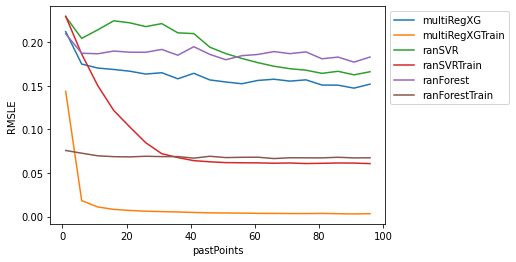

In [10]:
# plot results from loops for loopVar "pastPoints"

loopVarName = "pastPoints"

resultsDf = pickleLoad(f'{loopVarName}_resultsDf.pkl')

resultsDf.plot(x=loopVarName,y=resultsDf.keys().to_list().remove(loopVarName)).legend(bbox_to_anchor=(1,1))
plt.ylabel("RMSLE")

Text(0, 0.5, 'RMSLE')

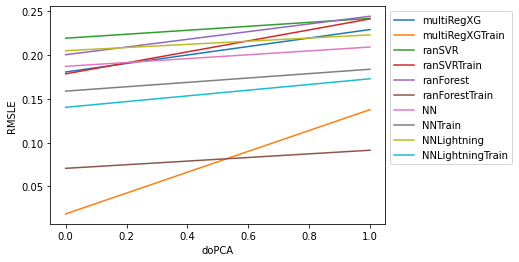

In [8]:
# Turn PCA on or off for 10 PCA components
loopVarName = "doPCA"

resultsDf = pickleLoad(f'{loopVarName}_resultsDf.pkl')

resultsDf.plot(x=loopVarName,y=resultsDf.keys().to_list().remove(loopVarName)).legend(bbox_to_anchor=(1,1))
plt.ylabel("RMSLE")

Text(0, 0.5, 'RMSLE')

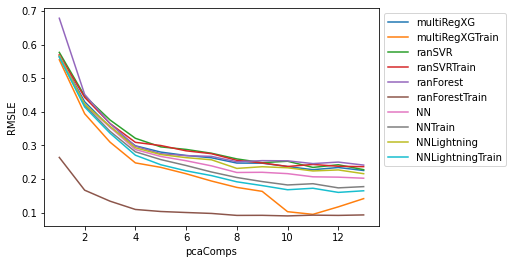

In [9]:
# Check effect of number of PCA components
loopVarName = "pcaComps"

resultsDf = pickleLoad(f'{loopVarName}_resultsDf.pkl')

resultsDf.plot(x=loopVarName,y=resultsDf.keys().to_list().remove(loopVarName)).legend(bbox_to_anchor=(1,1))
plt.ylabel("RMSLE")

Text(0, 0.5, 'RMSLE')

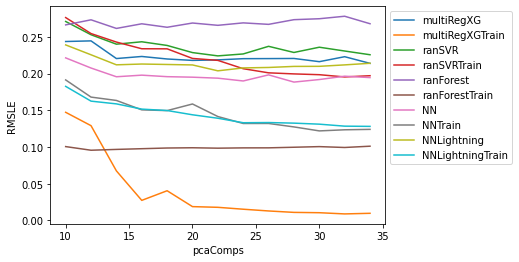

In [10]:
# Check effect of number of PCA components with 12 past data points included
loopVarName = "pcaComps"
extraText = "_12_PastPoints"

resultsDf = pickleLoad(f'{loopVarName}{extraText}_resultsDf.pkl')

resultsDf.plot(x=loopVarName,y=resultsDf.keys().to_list().remove(loopVarName)).legend(bbox_to_anchor=(1,1))
plt.ylabel("RMSLE")

Text(0, 0.5, 'RMSLE')

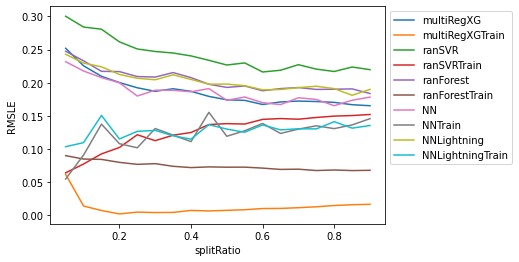

In [11]:
# Effect of different train test split ratio
loopVarName = "splitRatio"
extraText = "_12_PastPoints_No_PCA"

resultsDf = pickleLoad(f'{loopVarName}{extraText}_resultsDf.pkl')

resultsDf.plot(x=loopVarName,y=resultsDf.keys().to_list().remove(loopVarName)).legend(bbox_to_anchor=(1,1))
plt.ylabel("RMSLE")

Text(0, 0.5, 'RMSLE')

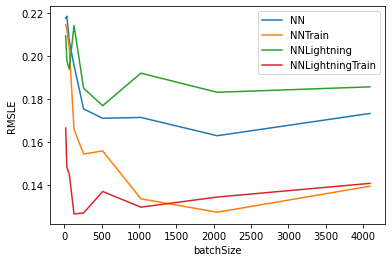

In [12]:
# Effect of batch size on training NNs
loopVarName = "batchSize"
extraText = "_12_PastPoints_No_PCA"

resultsDf = pickleLoad(f'{loopVarName}{extraText}_resultsDf.pkl')

resultsDf.plot(x=loopVarName,y=resultsDf.keys().to_list().remove(loopVarName)).legend(bbox_to_anchor=(1,1))
plt.ylabel("RMSLE")

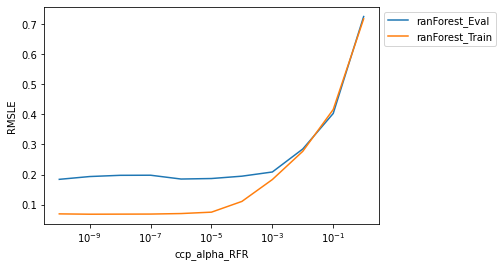

In [14]:

# Effect of ccp alpha penalization parameter for random forest

loopVarName = "ccp_alpha_RFR"
extraText = "_12_PastPoints_No_PCA"

resultsDf = pickleLoad(f'{loopVarName}{extraText}_resultsDf.pkl')

resultsDf.plot(x=loopVarName,y=resultsDf.keys().to_list().remove(loopVarName)).legend(bbox_to_anchor=(1,1))
plt.ylabel("RMSLE")
plt.xscale('log')

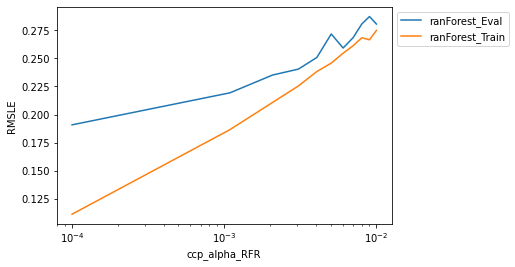

In [15]:

# Effect of ccp alpha penalization parameter for random forest

loopVarName = "ccp_alpha_RFR"
extraText = "_SmallerRange_12_PastPoints_No_PCA"

resultsDf = pickleLoad(f'{loopVarName}{extraText}_resultsDf.pkl')

resultsDf.plot(x=loopVarName,y=resultsDf.keys().to_list().remove(loopVarName)).legend(bbox_to_anchor=(1,1))
plt.ylabel("RMSLE")
plt.xscale('log')